This notebook trains a neural network to predict the energy from a descriptor. It then scores the model on a test set. At the end, it compares the predictions for the _whole_ data set and the true values. The structures that have an error larger than a certain threshold are printed to a file in xyz format so they can be visualised with VMD.

In [1]:
import joblib
import sys
sys.path.insert(0,'/Users/walfits/Repositories/Aglaia/')
import energies_NN as nn
import numpy as np
from sklearn import model_selection as modsel

In [2]:
# Loading the data
data = joblib.load("cc_kjmol_invdist_cartesian.bz")
X_desc = data["X_desc"]
X_cart = data["X_cartesian"]
y = np.reshape(data["y"], (data["y"].shape[0],))
print(X_desc.shape)

(20698, 21)


In [3]:
# Splitting the data
X_train, X_test, y_train, y_test = modsel.train_test_split(X_desc, y, test_size=0.2, random_state=42)
print(X_train.shape)

(16558, 21)


In [27]:
# Training the model
estimator = nn.Energies_NN(max_iter=20000, learning_rate_init=0.04, hidden_layer_sizes=(12,), batch_size=1000,
                              alpha= 0.0005, alpha_l1=0.0, tensorboard=False)

In [28]:
estimator.fit(X_train, y_train)
estimator.scoreFull(X_test, y_test)

(0.94818425504831727,
 17.664499437295408,
 12.947353221561716,
 84.566516503400635,
 123.70910797145916)

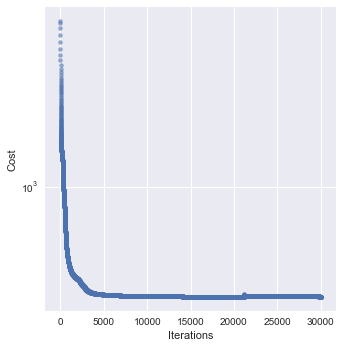

In [29]:
estimator.plot_cost()

In [30]:
y_pred = estimator.predict(X_desc)

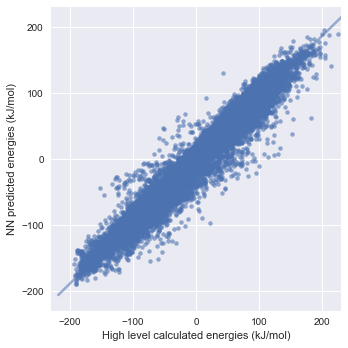

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()
df = pd.DataFrame()
df['High level calculated energies (kJ/mol)'] = y
df['NN predicted energies (kJ/mol)'] = y_pred
lm = sns.lmplot('High level calculated energies (kJ/mol)', 'NN predicted energies (kJ/mol)', data=df,
                scatter_kws={"s": 20, "alpha": 0.6}, line_kws={"alpha": 0.5})
lm.set(ylim=(-230,230), xlim=(-230,230))
plt.show()

In [32]:
err = y - y_pred

In [33]:
bad_struct_idx = []
threshold = 100
for i in range(y_pred.shape[0]):
    if err[i] > threshold or err[i] < -threshold:
        bad_struct_idx.append(i)
print(len(bad_struct_idx))

13


In [34]:
bad_struc_f = open("bad_struct.xyz", "w")
for idx in bad_struct_idx:
    bad_struc_f.write("7")
    bad_struc_f.write("\n\n")
    
    for i in range(0,28,4):
        for j in range(4):
            bad_struc_f.write(str(X_cart[idx][i+j]) + "\t")
        bad_struc_f.write("\n")

bad_struc_f.close()